In [1]:
import dask
import os 

src_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.chdir(src_path)

import gc
import tracemalloc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from src.seacast_tools.np_loaders import TargetsFromNumpy, PredictionsFromNumpy
from weatherbenchX.metrics import probabilistic
from weatherbenchX.metrics import base as metrics_base
from weatherbenchX import aggregation
from src.seacast_tools.ensemble_loaders import EnsembleFromNpLoaders
import pandas as pd
import xarray as xr
from matplotlib import gridspec

In [3]:
def flatten_to_2d(datos, mask, shape=(300, 300)):
    """
    Convierte un array 1D de datos en una matriz 2D usando una máscara.

    :param datos: Array de datos en formato 1D.
    :param mask: Máscara binaria en formato 1D.
    :param shape: Dimensiones de salida de la matriz 2D.
    :return: Matriz 2D con los valores de `datos` ubicados según `mask`.
    """
    mask = mask.flatten()
    temperature_map = np.zeros_like(mask, dtype=float)

    j = 0
    for i in range(len(mask)):
        if mask[i] == 1:
            temperature_map[i] = datos[j]
            j += 1

    return temperature_map.reshape(shape)

def plot_temperature_map(temperature_map, cmap="inferno"):
    """
    Genera y muestra un mapa de temperatura.

    :param temperature_map: Matriz 2D con los datos a visualizar.
    :param cmap: Colormap para la visualización.
    :param norm: Normalización de los valores para mejorar la escala de colores.
    """
    plt.figure(figsize=(6, 6))

    norm = Normalize(vmin=np.min(temperature_map[temperature_map != 0]),
                        vmax=np.max(temperature_map))
    plt.imshow(temperature_map, cmap=cmap, origin='lower', norm=norm)

    plt.colorbar(label="Temperatura")
    plt.title("Mapa de Temperatura")
    plt.show()

tracemalloc.start()
mask = np.load("data/atlantic/static/sea_mask.npy")

In [3]:
dict_metric_names = {
    "crps.sst_temperature": "CRPS",
    "rmse_unb.sst_temperature": "RMSE (sin sesgo)",
    "spread_skill_ratio.sst_temperature": "Spread/skill",
    "spread_skill_ratio_unb.sst_temperature": "Spread/skill (sin sesgo)",
    "rmse.sst_temperature": "RMSE",
    "mae.sst_temperature": "MAE",
    "bias.sst_temperature": "Sesgo",
}

In [15]:
metrics = {
    "spread_skill_ratio": probabilistic.SpreadSkillRatio(skipna_ensemble=True),
    "spread_skill_ratio_unb": probabilistic.UnbiasedSpreadSkillRatio(skipna_ensemble=True),
}

aggregator = aggregation.Aggregator(
  reduce_dims=['latitude', 'longitude'], skipna=True
)

In [14]:
def get_skill_spread_ratio(mse, std):
    return np.sqrt(std) / np.sqrt(mse)

def get_crps(skill, spread):
    return skill - 0.5 * spread

def get_rmse_unb(mse):
    return np.sqrt(mse)

def get_metrics_probabilistic(statistics):
    var = statistics.mean_statistics()

    mse_unbiased = var["UnbiasedEnsembleMeanSquaredError_number_skipna_ensemble_True"]['sst_temperature']
    mse_biased = var["SquaredError_predictions_ensemble_mean_self._ensemble_dim='number'_self._skipna=True"]['sst_temperature']
    spread = var["EnsembleVariance_number_skipna_ensemble_True"]['sst_temperature']

    spread_skill_ratio_unb = get_skill_spread_ratio(mse_unbiased, spread)
    spread_skill_ratio = get_skill_spread_ratio(mse_biased, spread)

    ds = xr.Dataset({
        "spread_skill_ratio.sst_temperature": spread_skill_ratio,
        "spread_skill_ratio_unb.sst_temperature": spread_skill_ratio_unb,
    })

    if "lead_time" in ds.coords:
        ds["lead_time"] = ds["lead_time"].astype("timedelta64[D]")

    return ds

In [13]:
variables = ["sst_temperature"]
directory = r"data\atlantic\samples\test"
extra_variables = ["coordinates", "mask"]
extra_files = [r"data\atlantic\static\coordinates.npy", r"data\atlantic\static\sea_mask.npy"]    

In [12]:
def process_and_save_metrics(date_ranges, year, noise_type, directories):
    all_metrics = []
    all_statistics = []
    
    for date_range in date_ranges:
        print(f"Procesando rango de fechas: {date_range[0]} a {date_range[1]}")
        loaders = []
        for directory in directories:
            predictions = PredictionsFromNumpy(
                path=directory,
                variables=variables,
                extra_variables=extra_variables,
                extra_files=extra_files,
                dates=date_range
            )
            loaders.append(predictions)

        ensemble = EnsembleFromNpLoaders(loaders=loaders)
        predictions_dataset = ensemble.build_ensemble()

        directory = r"data\atlantic\samples\test"
        
        targets = TargetsFromNumpy(
            path=directory,
            variables=variables,
            extra_variables=extra_variables,
            extra_files=extra_files,
            dates=date_range
        )
        targets_dataset = targets.load_chunk()
        
        statistics = metrics_base.compute_unique_statistics_for_all_metrics(
            metrics, predictions_dataset, targets_dataset
        )

        aggregation_state = aggregator.aggregate_statistics(statistics)
        dataset_metrics = get_metrics_probabilistic(aggregation_state)

        dataset_metrics["lead_time"] = dataset_metrics["lead_time"].astype("timedelta64[D]")

        all_metrics.append(dataset_metrics)
        all_statistics.append(statistics)

        del predictions_dataset, targets_dataset, statistics, aggregation_state, dataset_metrics, ensemble
        gc.collect()

    combined_metrics = xr.concat(all_metrics, dim="init_time")
    combined_metrics.astype(np.float32).to_netcdf(f"data/atlantic/predictions/ensemble_{noise_type}_{year}_manual.nc")

#### Pruebas Gaussian (0.1)

In [8]:
directories_gaussian = [r"data\atlantic\predictions\gaussian\run-20250525_134738-chih23im\files\predictions", r"data\atlantic\predictions\gaussian\run-20250525_161837-5n7qh3vq\files\predictions", r"data\atlantic\predictions\gaussian\run-20250525_202636-9ucmeenc\files\predictions", r"data\atlantic\predictions\gaussian\run-20250526_001455-nfmwznoc\files\predictions",
r"data\atlantic\predictions\gaussian\run-20250527_190605-gh4g5mks\files\predictions"] 

date_ranges_2022 = [
    (pd.Timestamp("2022-01-01"), pd.Timestamp("2022-03-31")),
    (pd.Timestamp("2022-04-01"), pd.Timestamp("2022-06-30")),
    (pd.Timestamp("2022-07-01"), pd.Timestamp("2022-09-30")),
    (pd.Timestamp("2022-10-01"), pd.Timestamp("2022-12-31"))
]

date_ranges_2023 = [
    (pd.Timestamp("2023-01-01"), pd.Timestamp("2023-03-31")),
    (pd.Timestamp("2023-04-01"), pd.Timestamp("2023-06-30")),
    (pd.Timestamp("2023-07-01"), pd.Timestamp("2023-09-08")),
    (pd.Timestamp("2023-09-09"), pd.Timestamp("2023-12-17"))
]

In [9]:
process_and_save_metrics(date_ranges_2022, "2022", "gaussian", directories_gaussian)

Procesando rango de fechas: 2022-01-01 00:00:00 a 2022-03-31 00:00:00
Loaded 88 data entries from data\atlantic\predictions\gaussian\run-20250525_134738-chih23im\files\predictions


Loaded 88 data entries from data\atlantic\predictions\gaussian\run-20250525_161837-5n7qh3vq\files\predictions
Loaded 88 data entries from data\atlantic\predictions\gaussian\run-20250525_202636-9ucmeenc\files\predictions
Loaded 88 data entries from data\atlantic\predictions\gaussian\run-20250526_001455-nfmwznoc\files\predictions
Loaded 88 data entries from data\atlantic\predictions\gaussian\run-20250527_190605-gh4g5mks\files\predictions
Loaded 88 data entries from data\atlantic\samples\test
Procesando rango de fechas: 2022-04-01 00:00:00 a 2022-06-30 00:00:00
Loaded 89 data entries from data\atlantic\predictions\gaussian\run-20250525_134738-chih23im\files\predictions
Loaded 89 data entries from data\atlantic\predictions\gaussian\run-20250525_161837-5n7qh3vq\files\predictions
Loaded 89 data entries from data\atlantic\predictions\gaussian\run-20250525_202636-9ucmeenc\files\predictions
Loaded 89 data entries from data\atlantic\predictions\gaussian\run-20250526_001455-nfmwznoc\files\predict

In [10]:
process_and_save_metrics(date_ranges_2023, "2023", "gaussian", directories_gaussian)

Procesando rango de fechas: 2023-01-01 00:00:00 a 2023-03-31 00:00:00
Loaded 88 data entries from data\atlantic\predictions\gaussian\run-20250525_134738-chih23im\files\predictions
Loaded 88 data entries from data\atlantic\predictions\gaussian\run-20250525_161837-5n7qh3vq\files\predictions
Loaded 88 data entries from data\atlantic\predictions\gaussian\run-20250525_202636-9ucmeenc\files\predictions
Loaded 88 data entries from data\atlantic\predictions\gaussian\run-20250526_001455-nfmwznoc\files\predictions
Loaded 88 data entries from data\atlantic\predictions\gaussian\run-20250527_190605-gh4g5mks\files\predictions
Loaded 88 data entries from data\atlantic\samples\test
Procesando rango de fechas: 2023-04-01 00:00:00 a 2023-06-30 00:00:00
Loaded 89 data entries from data\atlantic\predictions\gaussian\run-20250525_134738-chih23im\files\predictions
Loaded 89 data entries from data\atlantic\predictions\gaussian\run-20250525_161837-5n7qh3vq\files\predictions
Loaded 89 data entries from data\at

In [2]:
metrics_2022 = xr.open_dataset("data/atlantic/predictions/ensemble_gaussian_2022_manual.nc")
metrics_2023 = xr.open_dataset("data/atlantic/predictions/ensemble_gaussian_2023_manual.nc")

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_21392\4180575493.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  metrics_2022 = xr.open_dataset("data/atlantic/predictions/ensemble_gaussian_2022_manual.nc")
C:\Users\Alejandro\AppData\Local\Temp\ipykernel_21392\4180575493.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  metrics_2023 = xr.open_dataset("data/atlantic/predictions/ensemble_gaussian_2023_manual.nc")


In [12]:
combined_metrics_gaussian = xr.concat([metrics_2022, metrics_2023], dim="init_time")

combined_metrics_gaussian.to_netcdf("data/atlantic/predictions/metrics_combined_gaussian_manual.nc")

#### Pruebas Gaussian (0.01)

#### Pruebas Gaussian (0.01)

In [16]:
date_ranges_2022 = [
    (pd.Timestamp("2022-01-01"), pd.Timestamp("2022-03-31")),
    (pd.Timestamp("2022-04-01"), pd.Timestamp("2022-06-30")),
    (pd.Timestamp("2022-07-01"), pd.Timestamp("2022-09-30")),
    (pd.Timestamp("2022-10-01"), pd.Timestamp("2022-12-31"))
]

date_ranges_2023 = [
    (pd.Timestamp("2023-01-01"), pd.Timestamp("2023-03-31")),
    (pd.Timestamp("2023-04-01"), pd.Timestamp("2023-06-30")),
    (pd.Timestamp("2023-07-01"), pd.Timestamp("2023-09-08")),
    (pd.Timestamp("2023-09-09"), pd.Timestamp("2023-12-17"))
]

directories_gaussian = [r"data\atlantic\predictions\gaussian_01\run-20250622_022313-61kverwu\files\predictions", r"data\atlantic\predictions\gaussian_01\run-20250622_105157-81a2hgj5\files\predictions", r"data\atlantic\predictions\gaussian_01\run-20250622_151113-ye4zg4wy\files\predictions", r"data\atlantic\predictions\gaussian_01\run-20250622_174610-d8lg34hb\files\predictions",
r"data\atlantic\predictions\gaussian_01\run-20250622_201726-dfy7vvwy\files\predictions"] 

In [17]:
process_and_save_metrics(date_ranges_2022, "2022", "gaussian_01", directories_gaussian)

Procesando rango de fechas: 2022-01-01 00:00:00 a 2022-03-31 00:00:00
Loaded 88 data entries from data\atlantic\predictions\gaussian_01\run-20250622_022313-61kverwu\files\predictions
Loaded 88 data entries from data\atlantic\predictions\gaussian_01\run-20250622_105157-81a2hgj5\files\predictions
Loaded 88 data entries from data\atlantic\predictions\gaussian_01\run-20250622_151113-ye4zg4wy\files\predictions
Loaded 88 data entries from data\atlantic\predictions\gaussian_01\run-20250622_174610-d8lg34hb\files\predictions
Loaded 88 data entries from data\atlantic\predictions\gaussian_01\run-20250622_201726-dfy7vvwy\files\predictions
Loaded 88 data entries from data\atlantic\samples\test
Procesando rango de fechas: 2022-04-01 00:00:00 a 2022-06-30 00:00:00
Loaded 89 data entries from data\atlantic\predictions\gaussian_01\run-20250622_022313-61kverwu\files\predictions
Loaded 89 data entries from data\atlantic\predictions\gaussian_01\run-20250622_105157-81a2hgj5\files\predictions
Loaded 89 data

In [18]:
process_and_save_metrics(date_ranges_2023, "2023", "gaussian_01", directories_gaussian)

Procesando rango de fechas: 2023-01-01 00:00:00 a 2023-03-31 00:00:00


Loaded 88 data entries from data\atlantic\predictions\gaussian_01\run-20250622_022313-61kverwu\files\predictions
Loaded 88 data entries from data\atlantic\predictions\gaussian_01\run-20250622_105157-81a2hgj5\files\predictions
Loaded 88 data entries from data\atlantic\predictions\gaussian_01\run-20250622_151113-ye4zg4wy\files\predictions
Loaded 88 data entries from data\atlantic\predictions\gaussian_01\run-20250622_174610-d8lg34hb\files\predictions
Loaded 88 data entries from data\atlantic\predictions\gaussian_01\run-20250622_201726-dfy7vvwy\files\predictions
Loaded 88 data entries from data\atlantic\samples\test
Procesando rango de fechas: 2023-04-01 00:00:00 a 2023-06-30 00:00:00
Loaded 89 data entries from data\atlantic\predictions\gaussian_01\run-20250622_022313-61kverwu\files\predictions
Loaded 89 data entries from data\atlantic\predictions\gaussian_01\run-20250622_105157-81a2hgj5\files\predictions
Loaded 89 data entries from data\atlantic\predictions\gaussian_01\run-20250622_15111

In [3]:
metrics_2022 = xr.open_dataset("data/atlantic/predictions/ensemble_gaussian_01_2022_manual.nc")
metrics_2023 = xr.open_dataset("data/atlantic/predictions/ensemble_gaussian_01_2023_manual.nc")

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_21392\2525855129.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  metrics_2022 = xr.open_dataset("data/atlantic/predictions/ensemble_gaussian_01_2022_manual.nc")
C:\Users\Alejandro\AppData\Local\Temp\ipykernel_21392\2525855129.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  metrics_2023 = xr.open_dataset("data/atlantic/predictions/ensemble_gaussian_01_2023_manual.nc")


In [4]:
combined_metrics_gaussian = xr.concat([metrics_2022, metrics_2023], dim="init_time")

combined_metrics_gaussian.to_netcdf("data/atlantic/predictions/metrics_combined_gaussian_01_manual.nc")

#### Pruebas 3d 2x3x3

In [18]:
directories_perlin_3_3 = [r"data\atlantic\predictions\perlin 3d 3_3\run-20250627_012546-3jljvvek\files\predictions", r"data\atlantic\predictions\perlin 3d 3_3\run-20250627_100731-9kdck9mt\files\predictions", r"data\atlantic\predictions\perlin 3d 3_3\run-20250627_163627-bqpbs0zk\files\predictions", r"data\atlantic\predictions\perlin 3d 3_3\run-20250627_194954-dommgq1v\files\predictions",
r"data\atlantic\predictions\perlin 3d 3_3\run-20250628_104937-sg864q0p\files\predictions"] 

date_ranges_2022 = [
    (pd.Timestamp("2022-01-01"), pd.Timestamp("2022-03-31")),
    (pd.Timestamp("2022-04-01"), pd.Timestamp("2022-06-30")),
    (pd.Timestamp("2022-07-01"), pd.Timestamp("2022-09-30")),
    (pd.Timestamp("2022-10-01"), pd.Timestamp("2022-12-31"))
]

date_ranges_2023 = [
    (pd.Timestamp("2023-01-01"), pd.Timestamp("2023-03-31")),
    (pd.Timestamp("2023-04-01"), pd.Timestamp("2023-06-30")),
    (pd.Timestamp("2023-07-01"), pd.Timestamp("2023-09-08")),
    (pd.Timestamp("2023-09-09"), pd.Timestamp("2023-12-17"))
]

In [19]:
variables = ["sst_temperature"]
directory = r"data\atlantic\samples\test"
extra_variables = ["coordinates", "mask"]
extra_files = [r"data\atlantic\static\coordinates.npy", r"data\atlantic\static\sea_mask.npy"]    

In [20]:
process_and_save_metrics(date_ranges_2022, "2022", "perlin_fractal", directories_perlin_3_3)

Procesando rango de fechas: 2022-01-01 00:00:00 a 2022-03-31 00:00:00


Loaded 88 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_012546-3jljvvek\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_100731-9kdck9mt\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_163627-bqpbs0zk\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_194954-dommgq1v\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250628_104937-sg864q0p\files\predictions
Loaded 88 data entries from data\atlantic\samples\test


c:\ProgramData\miniconda3\envs\tfg\lib\site-packages\xarray\core\computation.py:824: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


Procesando rango de fechas: 2022-04-01 00:00:00 a 2022-06-30 00:00:00
Loaded 89 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_012546-3jljvvek\files\predictions
Loaded 89 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_100731-9kdck9mt\files\predictions
Loaded 89 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_163627-bqpbs0zk\files\predictions
Loaded 89 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_194954-dommgq1v\files\predictions
Loaded 89 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250628_104937-sg864q0p\files\predictions
Loaded 89 data entries from data\atlantic\samples\test


c:\ProgramData\miniconda3\envs\tfg\lib\site-packages\xarray\core\computation.py:824: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


Procesando rango de fechas: 2022-07-01 00:00:00 a 2022-09-30 00:00:00
Loaded 90 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_012546-3jljvvek\files\predictions
Loaded 90 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_100731-9kdck9mt\files\predictions
Loaded 90 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_163627-bqpbs0zk\files\predictions
Loaded 90 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_194954-dommgq1v\files\predictions
Loaded 90 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250628_104937-sg864q0p\files\predictions
Loaded 90 data entries from data\atlantic\samples\test


c:\ProgramData\miniconda3\envs\tfg\lib\site-packages\xarray\core\computation.py:824: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


Procesando rango de fechas: 2022-10-01 00:00:00 a 2022-12-31 00:00:00
Loaded 90 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_012546-3jljvvek\files\predictions
Loaded 90 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_100731-9kdck9mt\files\predictions
Loaded 90 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_163627-bqpbs0zk\files\predictions
Loaded 90 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_194954-dommgq1v\files\predictions
Loaded 90 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250628_104937-sg864q0p\files\predictions
Loaded 90 data entries from data\atlantic\samples\test


c:\ProgramData\miniconda3\envs\tfg\lib\site-packages\xarray\core\computation.py:824: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [21]:
process_and_save_metrics(date_ranges_2023, "2023", "perlin_fractal", directories_perlin_3_3)

Procesando rango de fechas: 2023-01-01 00:00:00 a 2023-03-31 00:00:00
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_012546-3jljvvek\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_100731-9kdck9mt\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_163627-bqpbs0zk\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_194954-dommgq1v\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250628_104937-sg864q0p\files\predictions
Loaded 88 data entries from data\atlantic\samples\test


c:\ProgramData\miniconda3\envs\tfg\lib\site-packages\xarray\core\computation.py:824: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


Procesando rango de fechas: 2023-04-01 00:00:00 a 2023-06-30 00:00:00
Loaded 89 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_012546-3jljvvek\files\predictions
Loaded 89 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_100731-9kdck9mt\files\predictions
Loaded 89 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_163627-bqpbs0zk\files\predictions
Loaded 89 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_194954-dommgq1v\files\predictions
Loaded 89 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250628_104937-sg864q0p\files\predictions
Loaded 89 data entries from data\atlantic\samples\test


c:\ProgramData\miniconda3\envs\tfg\lib\site-packages\xarray\core\computation.py:824: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


Procesando rango de fechas: 2023-07-01 00:00:00 a 2023-09-08 00:00:00
Loaded 68 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_012546-3jljvvek\files\predictions
Loaded 68 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_100731-9kdck9mt\files\predictions
Loaded 68 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_163627-bqpbs0zk\files\predictions
Loaded 68 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_194954-dommgq1v\files\predictions
Loaded 68 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250628_104937-sg864q0p\files\predictions
Loaded 68 data entries from data\atlantic\samples\test


c:\ProgramData\miniconda3\envs\tfg\lib\site-packages\xarray\core\computation.py:824: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


Procesando rango de fechas: 2023-09-09 00:00:00 a 2023-12-17 00:00:00
Loaded 98 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_012546-3jljvvek\files\predictions
Loaded 98 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_100731-9kdck9mt\files\predictions
Loaded 98 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_163627-bqpbs0zk\files\predictions
Loaded 98 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250627_194954-dommgq1v\files\predictions
Loaded 98 data entries from data\atlantic\predictions\perlin 3d 3_3\run-20250628_104937-sg864q0p\files\predictions
Loaded 98 data entries from data\atlantic\samples\test


c:\ProgramData\miniconda3\envs\tfg\lib\site-packages\xarray\core\computation.py:824: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [22]:
metrics_2022 = xr.open_dataset("data/atlantic/predictions/ensemble_perlin_fractal_2022_manual.nc")
metrics_2023 = xr.open_dataset("data/atlantic/predictions/ensemble_perlin_fractal_2023_manual.nc")

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_18920\850520502.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  metrics_2022 = xr.open_dataset("data/atlantic/predictions/ensemble_perlin_fractal_2022_manual.nc")
C:\Users\Alejandro\AppData\Local\Temp\ipykernel_18920\850520502.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  metrics_2023 = xr.open_dataset("data/atlantic/predictions/ensemble_perlin_fractal_2023_manual.nc")


In [23]:
combined_metrics_perlin = xr.concat([metrics_2022, metrics_2023], dim="init_time")

combined_metrics_perlin.to_netcdf("data/atlantic/predictions/metrics_combined_perlin_3_3_manual.nc")

#### Perlin 3d 3x12_12

In [24]:
directories_perlin_12_12 = [r"data\atlantic\predictions\perlin 3d 12_12\run-20250630_095751-nutjqhw9\files\predictions", r"data\atlantic\predictions\perlin 3d 12_12\run-20250630_155653-lki2b3l0\files\predictions", r"data\atlantic\predictions\perlin 3d 12_12\run-20250630_192224-0oydiur0\files\predictions", r"data\atlantic\predictions\perlin 3d 12_12\run-20250630_214521-lu90qdqu\files\predictions",
r"data\atlantic\predictions\perlin 3d 12_12\run-20250701_102212-hy3jgvnj\files\predictions"] 

date_ranges_2022 = [
    (pd.Timestamp("2022-01-01"), pd.Timestamp("2022-03-31")),
    (pd.Timestamp("2022-04-01"), pd.Timestamp("2022-06-30")),
    (pd.Timestamp("2022-07-01"), pd.Timestamp("2022-09-30")),
    (pd.Timestamp("2022-10-01"), pd.Timestamp("2022-12-31"))
]

date_ranges_2023 = [
    (pd.Timestamp("2023-01-01"), pd.Timestamp("2023-03-31")),
    (pd.Timestamp("2023-04-01"), pd.Timestamp("2023-06-30")),
    (pd.Timestamp("2023-07-01"), pd.Timestamp("2023-09-08")),
    (pd.Timestamp("2023-09-09"), pd.Timestamp("2023-12-17"))
]

In [25]:
variables = ["sst_temperature"]
directory = r"data\atlantic\samples\test"
extra_variables = ["coordinates", "mask"]
extra_files = [r"data\atlantic\static\coordinates.npy", r"data\atlantic\static\sea_mask.npy"]    

In [26]:
process_and_save_metrics(date_ranges_2022, "2022", "perlin_3d_12_12", directories_perlin_12_12)

Procesando rango de fechas: 2022-01-01 00:00:00 a 2022-03-31 00:00:00
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_095751-nutjqhw9\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_155653-lki2b3l0\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_192224-0oydiur0\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_214521-lu90qdqu\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250701_102212-hy3jgvnj\files\predictions
Loaded 88 data entries from data\atlantic\samples\test
Procesando rango de fechas: 2022-04-01 00:00:00 a 2022-06-30 00:00:00
Loaded 89 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_095751-nutjqhw9\files\predictions
Loaded 89 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_155653-lki2b3l0\file

In [27]:
process_and_save_metrics(date_ranges_2023, "2023", "erlin_3d_12_12", directories_perlin_12_12)

Procesando rango de fechas: 2023-01-01 00:00:00 a 2023-03-31 00:00:00


Loaded 88 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_095751-nutjqhw9\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_155653-lki2b3l0\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_192224-0oydiur0\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_214521-lu90qdqu\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250701_102212-hy3jgvnj\files\predictions
Loaded 88 data entries from data\atlantic\samples\test
Procesando rango de fechas: 2023-04-01 00:00:00 a 2023-06-30 00:00:00
Loaded 89 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_095751-nutjqhw9\files\predictions
Loaded 89 data entries from data\atlantic\predictions\perlin 3d 12_12\run-20250630_155653-lki2b3l0\files\predictions
Loaded 89 data entries from data\atlantic\predictions\pe

In [28]:
metrics_2022 = xr.open_dataset("data/atlantic/predictions/ensemble_perlin_3d_12_12_2022_manual.nc")
metrics_2023 = xr.open_dataset("data/atlantic/predictions/ensemble_erlin_3d_12_12_2023_manual.nc")

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_18920\3395133260.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  metrics_2022 = xr.open_dataset("data/atlantic/predictions/ensemble_perlin_3d_12_12_2022_manual.nc")
C:\Users\Alejandro\AppData\Local\Temp\ipykernel_18920\3395133260.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  metrics_2023 = xr.open_dataset("data/atlantic/predictions/ensemble_erlin_3d_12_12_2023_manual.nc")


In [29]:
combined_metrics_perlin_12_12 = xr.concat([metrics_2022, metrics_2023], dim="init_time")

combined_metrics_perlin_12_12.to_netcdf("data/atlantic/predictions/metrics_combined_perlin_12_12_manual.nc")

#### Perlin Fractal 2d 005 esc

In [30]:
directories_perlin_fractal_2d_005 = [r"data\atlantic\predictions\perlin_fractal_2d_005\run-20250702_164853-1qvul8qe\files\predictions", r"data\atlantic\predictions\perlin_fractal_2d_005\run-20250702_215342-znfh11ww\files\predictions", r"data\atlantic\predictions\perlin_fractal_2d_005\run-20250703_104826-tizjx546\files\predictions", r"data\atlantic\predictions\perlin_fractal_2d_005\run-20250703_172314-hx6thv8d\files\predictions",
r"data\atlantic\predictions\perlin_fractal_2d_005\run-20250703_220724-k1bggi8k\files\predictions"] 

date_ranges_2022 = [
    (pd.Timestamp("2022-01-01"), pd.Timestamp("2022-03-31")),
    (pd.Timestamp("2022-04-01"), pd.Timestamp("2022-06-30")),
    (pd.Timestamp("2022-07-01"), pd.Timestamp("2022-09-30")),
    (pd.Timestamp("2022-10-01"), pd.Timestamp("2022-12-31"))
]

date_ranges_2023 = [
    (pd.Timestamp("2023-01-01"), pd.Timestamp("2023-03-31")),
    (pd.Timestamp("2023-04-01"), pd.Timestamp("2023-06-30")),
    (pd.Timestamp("2023-07-01"), pd.Timestamp("2023-09-08")),
    (pd.Timestamp("2023-09-09"), pd.Timestamp("2023-12-17"))
]

In [31]:
variables = ["sst_temperature"]
directory = r"data\atlantic\samples\test"
extra_variables = ["coordinates", "mask"]
extra_files = [r"data\atlantic\static\coordinates.npy", r"data\atlantic\static\sea_mask.npy"]    

In [32]:
process_and_save_metrics(date_ranges_2022, "2022", "perlin_fractal_2d_005", directories_perlin_fractal_2d_005)

Procesando rango de fechas: 2022-01-01 00:00:00 a 2022-03-31 00:00:00
Loaded 88 data entries from data\atlantic\predictions\perlin_fractal_2d_005\run-20250702_164853-1qvul8qe\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin_fractal_2d_005\run-20250702_215342-znfh11ww\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin_fractal_2d_005\run-20250703_104826-tizjx546\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin_fractal_2d_005\run-20250703_172314-hx6thv8d\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin_fractal_2d_005\run-20250703_220724-k1bggi8k\files\predictions
Loaded 88 data entries from data\atlantic\samples\test
Procesando rango de fechas: 2022-04-01 00:00:00 a 2022-06-30 00:00:00
Loaded 89 data entries from data\atlantic\predictions\perlin_fractal_2d_005\run-20250702_164853-1qvul8qe\files\predictions
Loaded 89 data entries from data\atlantic\predictions\perlin_fracta

In [33]:
process_and_save_metrics(date_ranges_2023, "2023", "perlin_fractal_2d_005", directories_perlin_fractal_2d_005)

Procesando rango de fechas: 2023-01-01 00:00:00 a 2023-03-31 00:00:00
Loaded 88 data entries from data\atlantic\predictions\perlin_fractal_2d_005\run-20250702_164853-1qvul8qe\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin_fractal_2d_005\run-20250702_215342-znfh11ww\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin_fractal_2d_005\run-20250703_104826-tizjx546\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin_fractal_2d_005\run-20250703_172314-hx6thv8d\files\predictions
Loaded 88 data entries from data\atlantic\predictions\perlin_fractal_2d_005\run-20250703_220724-k1bggi8k\files\predictions
Loaded 88 data entries from data\atlantic\samples\test
Procesando rango de fechas: 2023-04-01 00:00:00 a 2023-06-30 00:00:00
Loaded 89 data entries from data\atlantic\predictions\perlin_fractal_2d_005\run-20250702_164853-1qvul8qe\files\predictions
Loaded 89 data entries from data\atlantic\predictions\perlin_fracta

In [34]:
metrics_2022 = xr.open_dataset("data/atlantic/predictions/ensemble_perlin_fractal_2d_005_2022_manual.nc")
metrics_2023 = xr.open_dataset("data/atlantic/predictions/ensemble_perlin_fractal_2d_005_2023_manual.nc")

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_18920\1159309481.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  metrics_2022 = xr.open_dataset("data/atlantic/predictions/ensemble_perlin_fractal_2d_005_2022_manual.nc")
C:\Users\Alejandro\AppData\Local\Temp\ipykernel_18920\1159309481.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  metrics_2023 = xr.open_dataset("data/atlantic/predictions/ensemble_perlin_fractal_2d_005_2023_manual.nc")


In [35]:
combined_metrics_perlin_fractal_2d_005  = xr.concat([metrics_2022, metrics_2023], dim="init_time")

combined_metrics_perlin_fractal_2d_005.to_netcdf("data/atlantic/predictions/metrics_combined_perlin_fractal_2d_005_manual.nc")

### Cargar datasets

In [2]:
combined_metrics_gaussian = xr.open_dataset("data/atlantic/predictions/metrics_combined_gaussian_manual.nc")
combined_metrics_gaussian_01 = xr.open_dataset("data/atlantic/predictions/metrics_combined_gaussian_01_manual.nc")
combined_metrics_perlin_3_3 = xr.open_dataset("data/atlantic/predictions/metrics_combined_perlin_3_3_manual.nc")
combined_metrics_perlin_12_12 = xr.open_dataset("data/atlantic/predictions/metrics_combined_perlin_12_12_manual.nc")
combined_metrics_perlin_fractal_2d_005 = xr.open_dataset("data/atlantic/predictions/metrics_combined_perlin_fractal_2d_005_manual.nc")

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_5760\3038219952.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  combined_metrics_gaussian = xr.open_dataset("data/atlantic/predictions/metrics_combined_gaussian_manual.nc")
C:\Users\Alejandro\AppData\Local\Temp\ipykernel_5760\3038219952.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  combined_metrics_gaussian_01 = xr.open_dataset("data/atlantic/predictions/metrics_combined_gaussian_01_manual.nc")
C:\Users\Alejandro\AppData\Local\Temp\ipykernel_5760\3038219952.py:3: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or

### Comparación gráficas

<Figure size 1200x500 with 0 Axes>

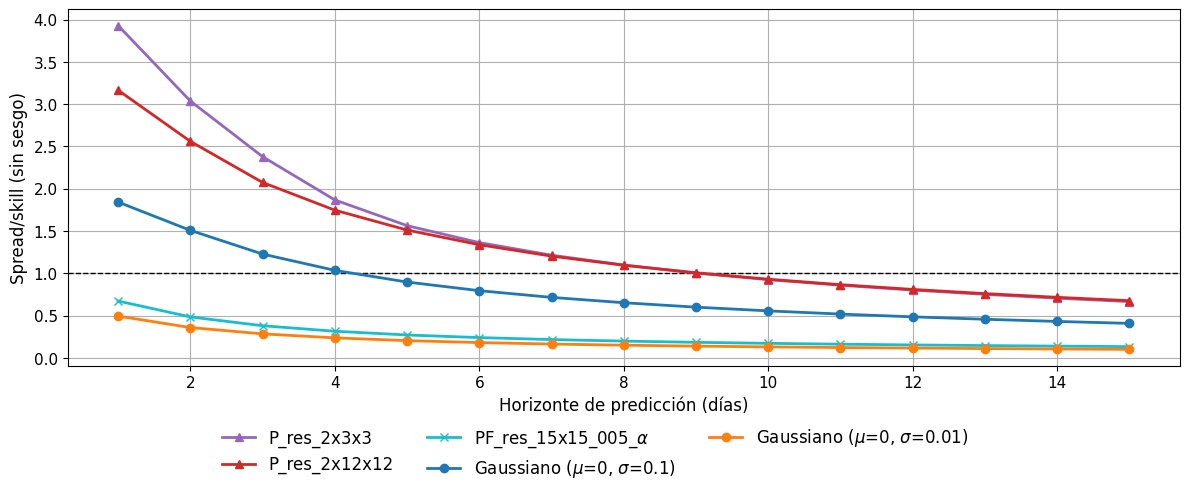

In [8]:
lead_days = combined_metrics_perlin_3_3["lead_time"] / np.timedelta64(1, 'D')

metrics = ["spread_skill_ratio_unb.sst_temperature"]

fig = plt.figure(figsize=(12, 5))

for idx, metric in enumerate(metrics):

    fig, ax = plt.subplots(figsize=(12, 5))

    ax.axhline(
        y=1,
        color="black",
        linestyle="--",
        linewidth=1,
    )

    ax.plot(
        lead_days,
        combined_metrics_perlin_3_3[metric].mean(dim="init_time"),
        label="P_res_2x3x3",
        marker='^',
        color="#9467bd",
        linewidth=2
    )
    ax.plot(
        lead_days,
        combined_metrics_perlin_12_12[metric].mean(dim="init_time"),
        label="P_res_2x12x12",
        marker='^',
        color="#d62728",
        linewidth=2
    )
    ax.plot(
        lead_days,
        combined_metrics_perlin_fractal_2d_005[metric].mean(dim="init_time"),
        label=r"PF_res_15x15_005_$\alpha$",
        marker='x',
        color="#17becf",
        linewidth=2
    )
    ax.plot(
        lead_days,
        combined_metrics_gaussian[metric].mean(dim="init_time"),
        label="Gaussiano ($\mu$=0, $\sigma$=0.1)",
        marker='o',
        color="#1f77b4",
        linewidth=2
    )
    ax.plot(
        lead_days,
        combined_metrics_gaussian_01[metric].mean(dim="init_time"),
        label="Gaussiano ($\mu$=0, $\sigma$=0.01)",
        marker='o',
        color="#ff7f0e",
        linewidth=2
    )

    ax.set_xlabel("Horizonte de predicción (días)", fontsize=12)
    ax.set_ylabel(dict_metric_names[metric], fontsize=12)
    ax.tick_params(labelsize=11)
    ax.grid(True)

handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc='lower center',
    fontsize=12,
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, -0.05)
)

plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.savefig("metrics/real_test/comparacion_SSR_probabilidad.svg", format="svg", bbox_inches='tight')
plt.show()